## Ví dụ 1

In [1]:
import numpy as np 
from numpy import linalg 
 
from sklearn.datasets import make_circles 
import matplotlib.pyplot as plt 
 
import cvxopt 
import cvxopt.solvers 
              
#Kernel linear: K(u, v) = u^T.v 
def linear_kernel(x1, x2): 
    return np.dot(x1, x2) 
 
#Kernel poly: K(u, v) = (r + \gamma u^T.v)^d 
def polynomial_kernel(x, y, gamma = 1, r = 1, d=3): 
    return (r + gamma*np.dot(x, y)) ** d 
 
#Kernel radial basic function (rbf) or gaussian: K(u, v) = e^[-\gamma|u-v|^2] 
def gaussian_kernel(x, y, sigma=5.0): 
    # gamma = 1.0/(2 * (sigma ** 2))  
    return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

In [2]:
class SVM(object): 
 
    def __init__(self, kernel=linear_kernel, C=None): 
        self.kernel = kernel 
        self.C = C 
        if self.C is not None: self.C = float(self.C)

    def fit(self, X, y): 
        n_samples, n_features = X.shape 
 
        # Solve Quadratic Programming problem 
        K = np.zeros((n_samples, n_samples)) 
        for i in range(n_samples): 
            for j in range(n_samples): 
                K[i,j] = self.kernel(X[i], X[j]) 
 
        P = cvxopt.matrix(np.outer(y,y) * K) 
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1,n_samples)) 
        b = cvxopt.matrix(0.0) 
 
        if self.C is None: 
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1)) 
            h = cvxopt.matrix(np.zeros(n_samples)) 
        else: 
            tmp1 = np.diag(np.ones(n_samples) * -1) 
            tmp2 = np.identity(n_samples) 
            G = cvxopt.matrix(np.vstack((tmp1, tmp2))) 
            tmp1 = np.zeros(n_samples) 
            tmp2 = np.ones(n_samples) * self.C 
            h = cvxopt.matrix(np.hstack((tmp1, tmp2))) 
 
        # solve QP problem 
        solution = cvxopt.solvers.qp(P, q, G, h, A, b) 
 
        # Lagrange multipliers a = \lambda 
        a = np.ravel(solution['x']) 
 
        # Support vectors have non zero lagrange multipliers 
        sv = a > 1e-5 
        ind = np.arange(len(a))[sv] 
        self.a = a[sv] 
        self.sv = X[sv] 
        self.sv_y = y[sv] 
        print("%d support vectors out of %d points" % (len(self.a), n_samples)) 
 
        # Intercept 
        self.b = 0 
        for n in range(len(self.a)): 
            self.b += self.sv_y[n] 
            self.b -= np.sum(self.a * self.sv_y * K[ind[n],sv]) 
        self.b /= len(self.a) 
 
        # Weight vector 
        if self.kernel == linear_kernel: 
            self.w = np.zeros(n_features) 
            for n in range(len(self.a)): 
                self.w += self.a[n] * self.sv_y[n] * self.sv[n] 
        else: 
            self.w = None
            
    def project(self, X): 
        if self.w is not None: 
            return np.dot(X, self.w) + self.b 
        else: 
            y_predict = np.zeros(len(X)) 
            for i in range(len(X)): 
                s = 0 
                for a, sv_y, sv in zip(self.a, self.sv_y, self.sv): 
                    s += a * sv_y * self.kernel(X[i], sv) 
                y_predict[i] = s 
            return y_predict + self.b 
 
    def predict(self, X): 
        return np.sign(self.project(X))

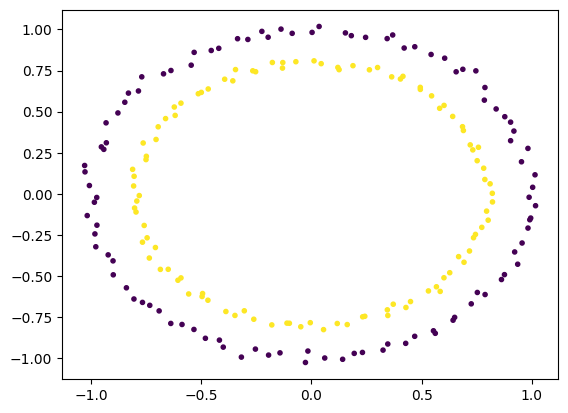

In [5]:
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn import svm 
from matplotlib.backends.backend_pdf import PdfPages 
from sklearn.datasets import make_circles 
 
# Generate dataset and targets 
X, Y = make_circles(n_samples = 200, noise = 0.02)
# visualizing data 
plt.scatter(X[:, 0], X[:, 1], c = Y, marker = '.') 
plt.show()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18324\4273091926.py:10: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(fignum, figsize=(5, 5))
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18324\4273091926.py:29: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(fignum, figsize=(5, 5))
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18324\4273091926.py:10: UserWarning: Ignoring specified arguments in this call because figure with num: 2 already exists
  plt.figure(fignum, figsize=(5, 5))
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18324\4273091926.py:29: UserWarning: Ignoring specified arguments in this call because figure with num: 2 already exists
  plt.figure(fignum, figsize=(5, 5))
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18324\4273091926.py:10: UserWarning: Ignoring specified arguments in this call because figure with num: 3 already exists
  plt.figure(fignum, figsiz

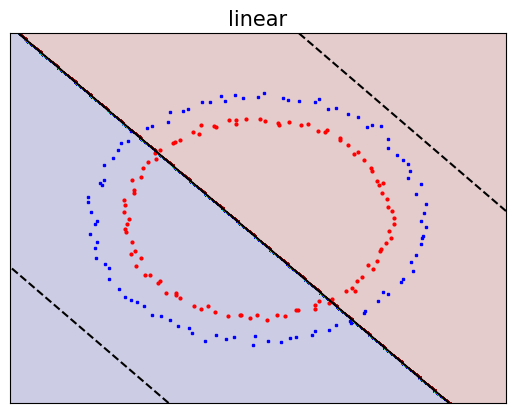

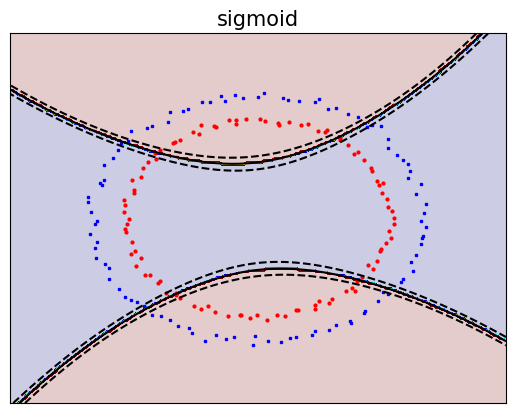

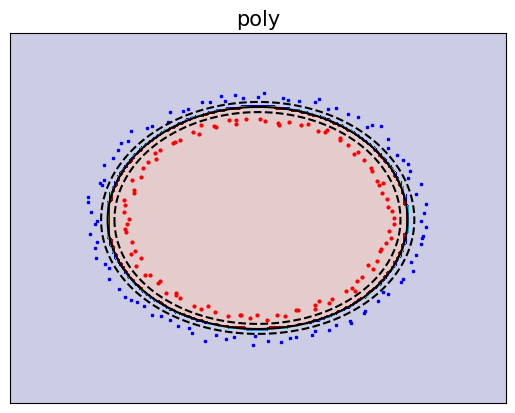

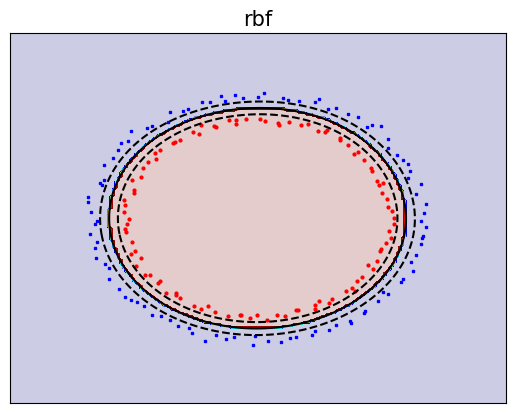

In [6]:
fignum = 1 
 
# fit the model 
for kernel in ('linear','sigmoid', 'poly', 'rbf'): 
    clf = svm.SVC(kernel=kernel, gamma=1, coef0 = 1) 
    clf.fit(X, Y) 
    with PdfPages(kernel + '3.pdf') as pdf: 
        # plot the line, the points, and the nearest vectors to the plane 
        fig, ax = plt.subplots() 
        plt.figure(fignum, figsize=(5, 5)) 
        plt.clf() 
 
        plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80, 
                    facecolors='None') 
        plt.plot(X[Y==0, 0], X[Y==0, 1], 'bs', markersize = 2) 
        plt.plot(X[Y==1, 0], X[Y==1, 1], 'ro', markersize = 2) 
 
        plt.axis('tight') 
        x_min = -1.5 
        x_max = 1.5 
        y_min = -1.5 
        y_max = 1.5 
 
        XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j] 
        Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()]) 
 
        # Put the result into a color plot 
        Z = Z.reshape(XX.shape) 
        plt.figure(fignum, figsize=(5, 5)) 
        CS = plt.contourf(XX, YY, np.sign(Z), 200, cmap='jet', alpha = .2) 
        plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'], 
                    levels=[-.5, 0, .5]) 
        plt.title(kernel, fontsize = 15) 
        plt.xlim(x_min, x_max) 
        plt.ylim(y_min, y_max) 
 
        plt.xticks(()) 
        plt.yticks(()) 
        fignum = fignum + 1 
        pdf.savefig() 
plt.show()

## Ví dụ 2

In [8]:
import numpy as np
import pandas as pd

# Load data from file
data = pd.read_csv('ex2data2.txt', header=None)

# Extract features (X) and labels (Y)
X = data.iloc[:, 0:2]  # First two columns as features
Y = data.iloc[:, 2]    # Third column as labels

# Print the shape of the data to verify
print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")

# Display first few rows of the data
print("\nFirst 5 rows of the data:")
print(data.head())

X shape: (118, 2)
Y shape: (118,)

First 5 rows of the data:
          0        1  2
0  0.051267  0.69956  1
1 -0.092742  0.68494  1
2 -0.213710  0.69225  1
3 -0.375000  0.50219  1
4 -0.513250  0.46564  1


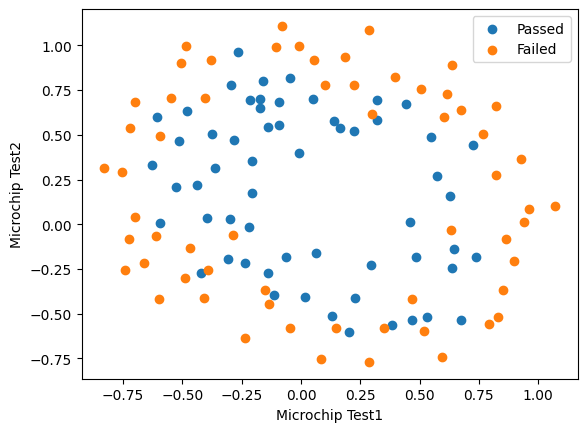

In [9]:
import matplotlib.pyplot as plt 
from sklearn import svm
from matplotlib.backends.backend_pdf import PdfPages 
 
# visualizing data 
mask = Y == 1 
passed = plt.scatter(X[mask][0].values, X[mask][1].values) 
failed = plt.scatter(X[~mask][0].values, X[~mask][1].values) 
plt.xlabel('Microchip Test1') 
plt.ylabel('Microchip Test2') 
plt.legend((passed, failed), ('Passed', 'Failed')) 
plt.show()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18324\3799825506.py:10: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(fignum, figsize=(5, 5))
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18324\3799825506.py:29: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(fignum, figsize=(5, 5))
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18324\3799825506.py:10: UserWarning: Ignoring specified arguments in this call because figure with num: 2 already exists
  plt.figure(fignum, figsize=(5, 5))
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18324\3799825506.py:29: UserWarning: Ignoring specified arguments in this call because figure with num: 2 already exists
  plt.figure(fignum, figsize=(5, 5))
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18324\3799825506.py:10: UserWarning: Ignoring specified arguments in this call because figure with num: 3 already exists
  plt.figure(fignum, figsiz

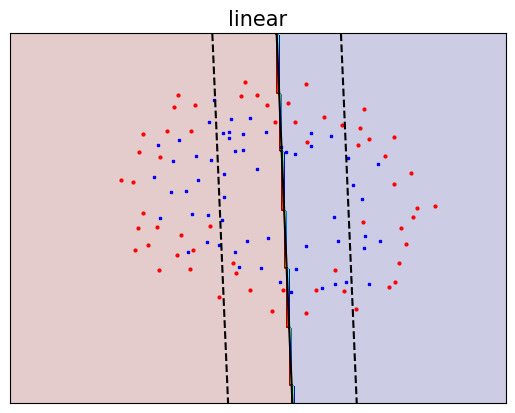

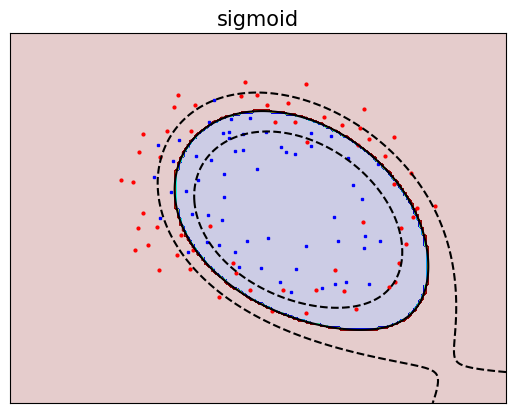

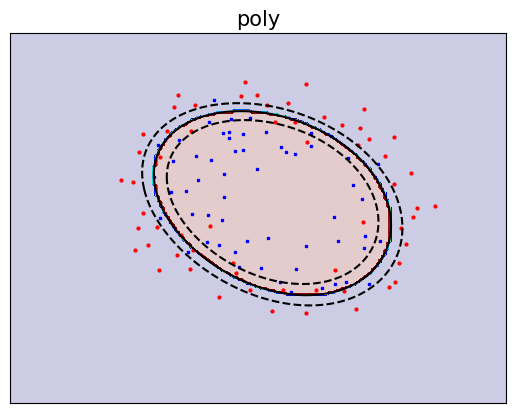

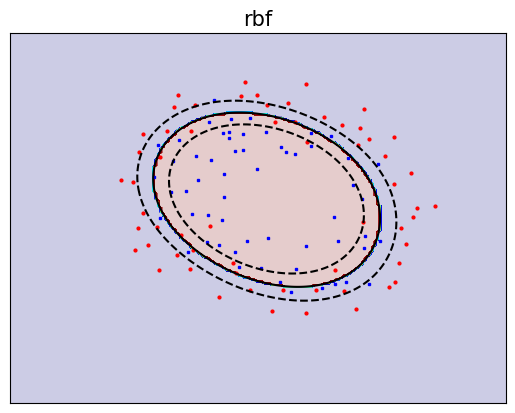

In [10]:
fignum = 1 
 
# fit the model 
for kernel in ('linear','sigmoid', 'poly', 'rbf'): 
    clf = svm.SVC(kernel=kernel, gamma=1, coef0 = 1) 
    clf.fit(X, Y) 
    with PdfPages(kernel + '3.pdf') as pdf: 
        # plot the line, the points, and the nearest vectors to the plane 
        fig, ax = plt.subplots() 
        plt.figure(fignum, figsize=(5, 5)) 
        plt.clf() 
 
        plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80, 
                    facecolors='None') 
        plt.plot(X[mask][0].values, X[mask][1].values, 'bs', markersize = 2) 
        plt.plot(X[~mask][0].values, X[~mask][1].values, 'ro', markersize = 2) 
 
        plt.axis('tight') 
        x_min = -1.5 
        x_max = 1.5 
        y_min = -1.5 
        y_max = 1.5 
 
        XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j] 
        Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()]) 
 
        # Put the result into a color plot 
        Z = Z.reshape(XX.shape) 
        plt.figure(fignum, figsize=(5, 5)) 
        CS = plt.contourf(XX, YY, np.sign(Z), 200, cmap='jet', alpha = .2) 
        plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'], 
                    levels=[-.5, 0, .5]) 
        plt.title(kernel, fontsize = 15) 
        plt.xlim(x_min, x_max) 
        plt.ylim(y_min, y_max) 
 
        plt.xticks(()) 
        plt.yticks(()) 
        fignum = fignum + 1 
        pdf.savefig() 
plt.show()

## Bài tập tự thực hành 1 (không có data)

In [ ]:
import scipy.io as sio 
from sklearn.svm import SVC

A = sio.loadmat('D:\\Teach_n_Train\\Machine Learning\\code\\data\\ARgender.mat') 
X_train = A['Y_train'].T  
X_test = A['Y_test'].T  
print(X_train.shape) 
N = 700 
y_train = A['label_train'].reshape(N) 
y_test = A['label_test'].reshape(N)

## Bài tập tự thực hành 2

In [11]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
 
dataset = pd.read_csv('dataset.csv') 
X = dataset.iloc[:, :-1].values 
y = dataset.iloc[:, -1].values 
 
from sklearn.model_selection import train_test_split 
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size = 0.25, random_state = 0) 
 
# Chuyển vị ma trận dữ liệu do ta đọc bằng Pandas => mỗi record là 1 dong 
from sklearn.preprocessing import StandardScaler 
sc = StandardScaler() 
XTrain = sc.fit_transform(XTrain) 
XTest = sc.transform(XTest)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18324\501309360.py:13: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(fignum, figsize=(5, 5))
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18324\501309360.py:37: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(fignum, figsize=(5, 5))
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18324\501309360.py:13: UserWarning: Ignoring specified arguments in this call because figure with num: 2 already exists
  plt.figure(fignum, figsize=(5, 5))
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18324\501309360.py:37: UserWarning: Ignoring specified arguments in this call because figure with num: 2 already exists
  plt.figure(fignum, figsize=(5, 5))
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18324\501309360.py:13: UserWarning: Ignoring specified arguments in this call because figure with num: 3 already exists
  plt.figure(fignum, figsize=(5,

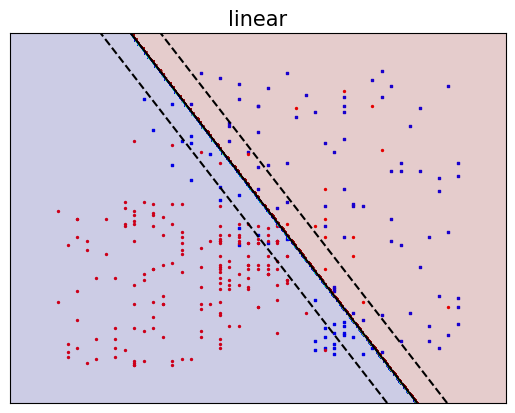

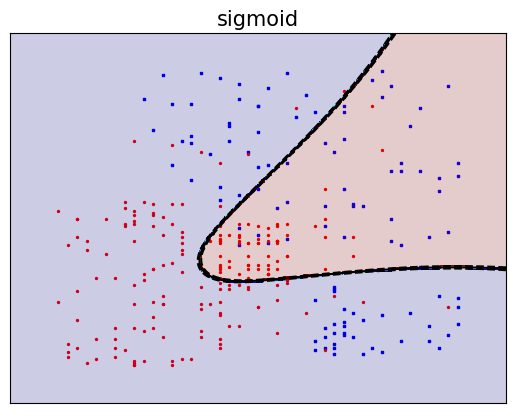

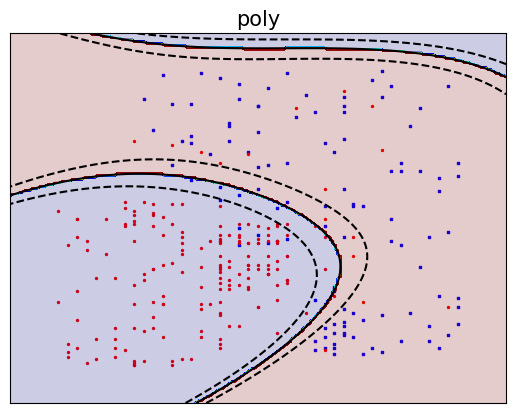

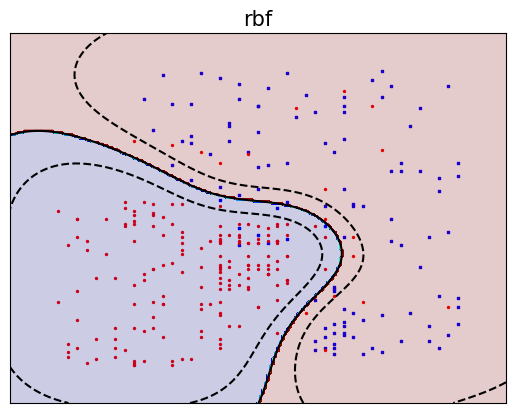

In [13]:
fignum = 1 
 
# Create mask for plotting
mask = yTrain == 1

# fit the model 
for kernel in ('linear','sigmoid', 'poly', 'rbf'): 
    clf = svm.SVC(kernel=kernel, gamma=1, coef0 = 1) 
    clf.fit(XTrain, yTrain) 
    with PdfPages(kernel + '3.pdf') as pdf: 
        # plot the line, the points, and the nearest vectors to the plane 
        fig, ax = plt.subplots() 
        plt.figure(fignum, figsize=(5, 5)) 
        plt.clf() 
 
        plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80, 
                    facecolors='None') 
        
        # Plot positive class points in blue
        plt.scatter(XTrain[mask, 0], XTrain[mask, 1], c='b', marker='s', s=2)
        # Plot negative class points in red  
        plt.scatter(XTrain[~mask, 0], XTrain[~mask, 1], c='r', marker='o', s=2)
 
        plt.axis('tight') 
        
        # Determine plot boundaries based on data ranges
        x_min = XTrain[:, 0].min() - 0.5
        x_max = XTrain[:, 0].max() + 0.5
        y_min = XTrain[:, 1].min() - 0.5
        y_max = XTrain[:, 1].max() + 0.5
 
        XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j] 
        Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()]) 
 
        # Put the result into a color plot 
        Z = Z.reshape(XX.shape) 
        plt.figure(fignum, figsize=(5, 5)) 
        CS = plt.contourf(XX, YY, np.sign(Z), 200, cmap='jet', alpha = .2) 
        plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'], 
                    levels=[-.5, 0, .5]) 
        plt.title(kernel, fontsize = 15) 
        plt.xlim(x_min, x_max) 
        plt.ylim(y_min, y_max) 
 
        plt.xticks(()) 
        plt.yticks(()) 
        fignum = fignum + 1 
        pdf.savefig() 
plt.show()


Results for linear kernel:
Accuracy: 0.9000
Precision: 0.9231
Recall: 0.7500
F1 Score: 0.8276
Confusion Matrix:
[[66  2]
 [ 8 24]]


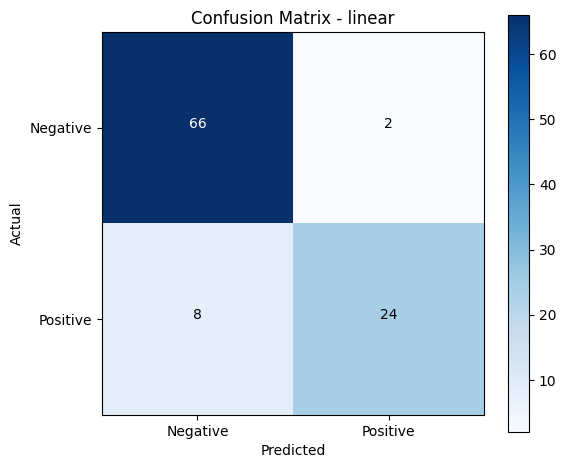


Results for sigmoid kernel:
Accuracy: 0.7000
Precision: 0.5312
Recall: 0.5312
F1 Score: 0.5312
Confusion Matrix:
[[53 15]
 [15 17]]


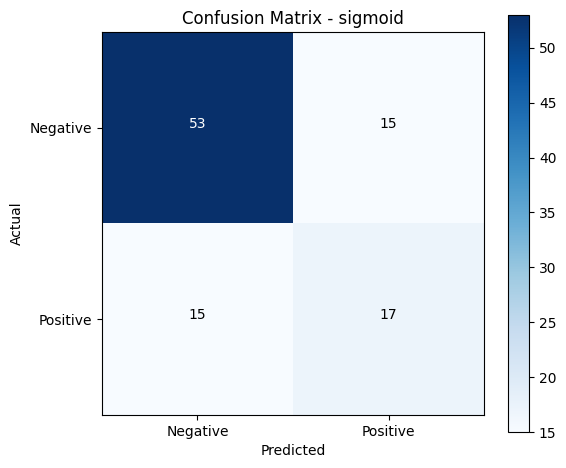


Results for poly kernel:
Accuracy: 0.9300
Precision: 0.8788
Recall: 0.9062
F1 Score: 0.8923
Confusion Matrix:
[[64  4]
 [ 3 29]]


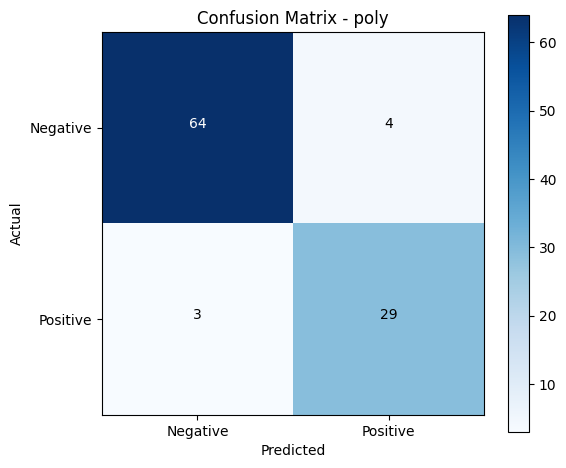


Results for rbf kernel:
Accuracy: 0.9300
Precision: 0.8788
Recall: 0.9062
F1 Score: 0.8923
Confusion Matrix:
[[64  4]
 [ 3 29]]


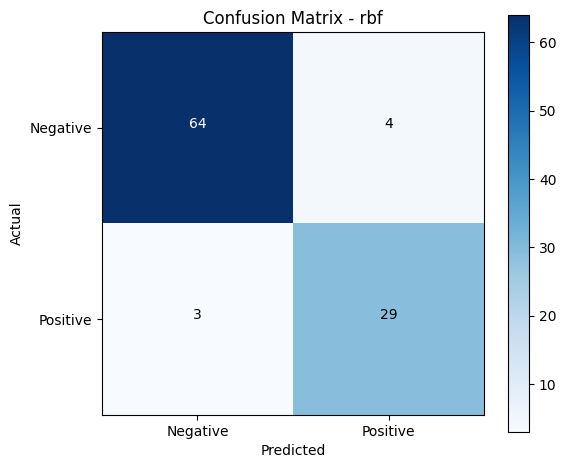

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Dictionary to store metrics for each kernel
metrics_results = {}

# fit the model and evaluate metrics
for kernel in ('linear', 'sigmoid', 'poly', 'rbf'):
    # Create and train the model
    clf = svm.SVC(kernel=kernel, gamma=1, coef0=1)
    clf.fit(XTrain, yTrain)
    
    # Make predictions on test set
    y_pred = clf.predict(XTest)
    
    # Calculate metrics
    accuracy = accuracy_score(yTest, y_pred)
    precision = precision_score(yTest, y_pred)
    recall = recall_score(yTest, y_pred)
    f1 = f1_score(yTest, y_pred)
    cm = confusion_matrix(yTest, y_pred)
    
    # Store metrics in dictionary
    metrics_results[kernel] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm
    }
    
    # Print results for this kernel
    print(f"\nResults for {kernel} kernel:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)
    
    # Optional: Plot confusion matrix
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {kernel}')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Negative', 'Positive'])
    plt.yticks(tick_marks, ['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    # Add text annotations to the confusion matrix
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()

## Bài tập tự thực hành 3

Dataset shape: (569, 30)
Number of classes: 2
Class distribution: [212 357]


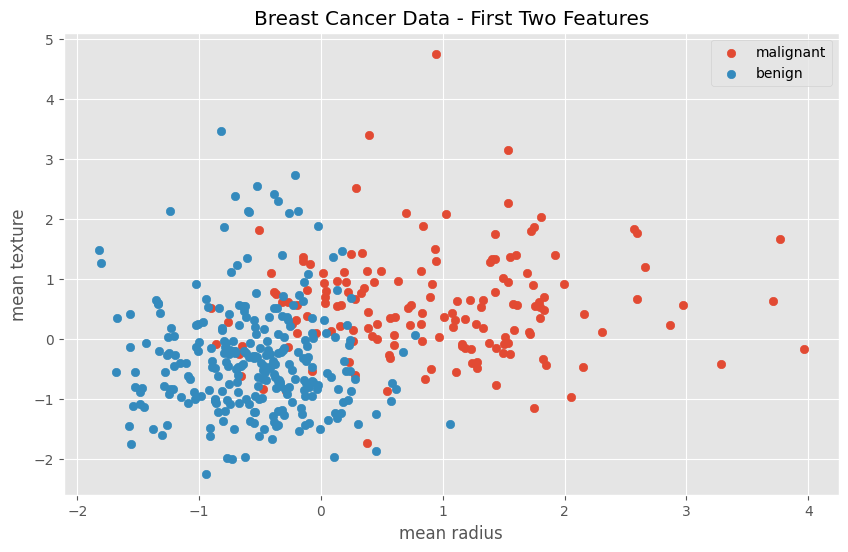


Training SVM with linear kernel...
Results for linear kernel:
Accuracy: 0.9720
Precision: 0.9775
Recall: 0.9775
F1 Score: 0.9775
Confusion Matrix:
[[52  2]
 [ 2 87]]


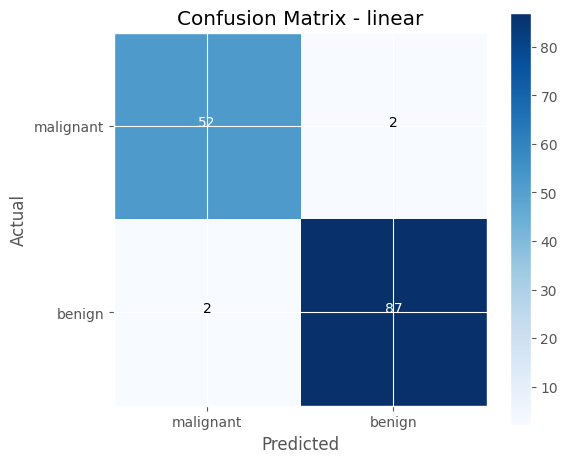

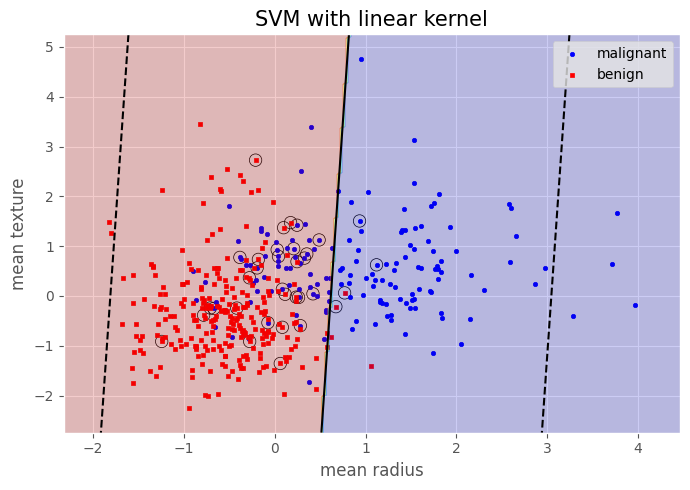


Training SVM with sigmoid kernel...
Results for sigmoid kernel:
Accuracy: 0.9580
Precision: 0.9770
Recall: 0.9551
F1 Score: 0.9659
Confusion Matrix:
[[52  2]
 [ 4 85]]


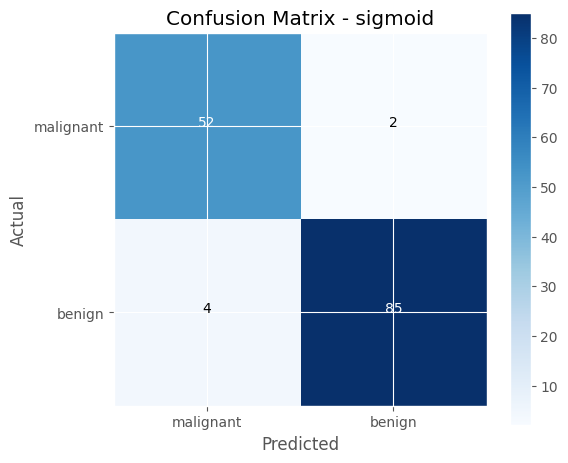

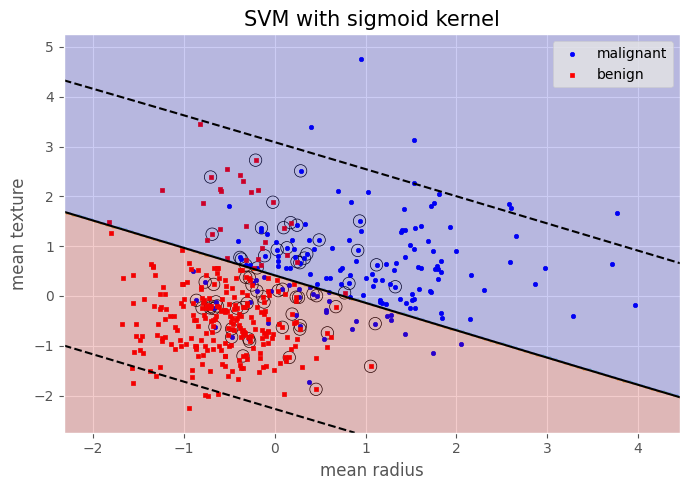


Training SVM with poly kernel...
Results for poly kernel:
Accuracy: 0.9021
Precision: 0.8641
Recall: 1.0000
F1 Score: 0.9271
Confusion Matrix:
[[40 14]
 [ 0 89]]


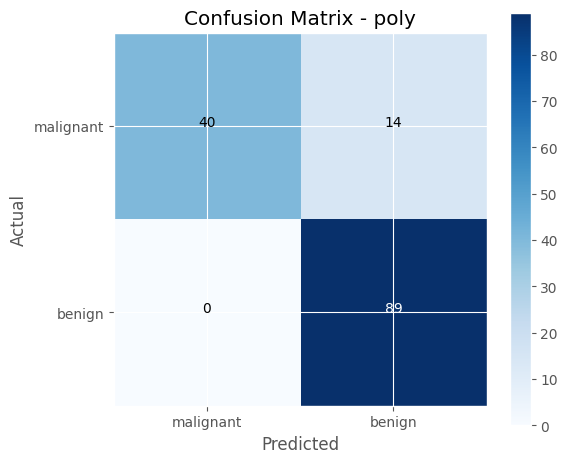

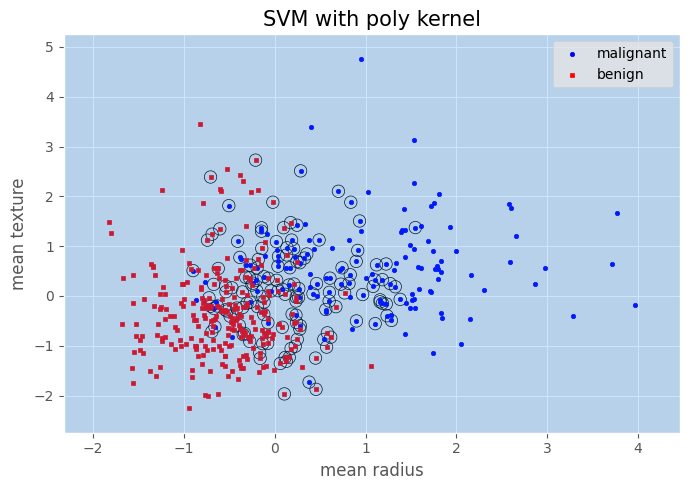


Training SVM with rbf kernel...
Results for rbf kernel:
Accuracy: 0.9720
Precision: 0.9775
Recall: 0.9775
F1 Score: 0.9775
Confusion Matrix:
[[52  2]
 [ 2 87]]


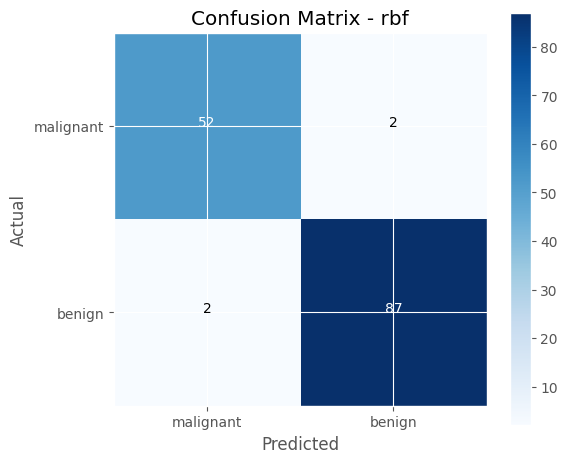

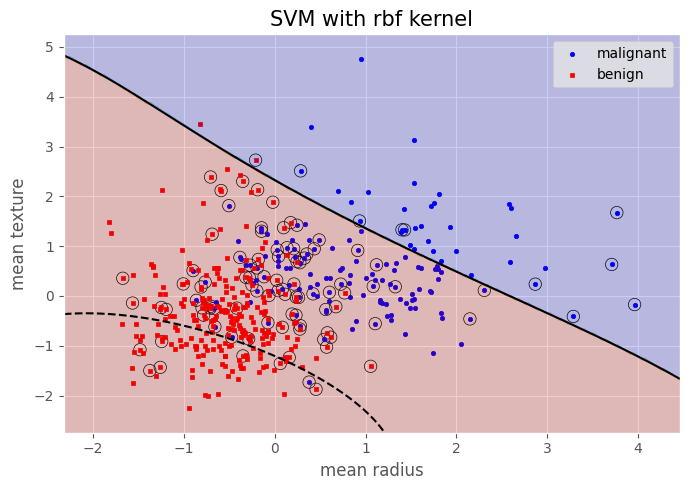

In [19]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn import svm
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.datasets import load_breast_cancer 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

data = load_breast_cancer()
X = data.data
y = data.target

# Display dataset info
print(f"Dataset shape: {X.shape}")
print(f"Number of classes: {len(np.unique(y))}")
print(f"Class distribution: {np.bincount(y)}")

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Visualize data (first two features for visualization purposes)
plt.figure(figsize=(10, 6))
for i, target_name in enumerate(data.target_names):
    plt.scatter(
        X_train[y_train == i, 0], 
        X_train[y_train == i, 1],
        label=target_name
    )
plt.xlabel(data.feature_names[0])
plt.ylabel(data.feature_names[1])
plt.title('Breast Cancer Data - First Two Features')
plt.legend()
plt.show()

# Train and evaluate SVM models with different kernels
metrics_results = {}
fignum = 1

# Create mask for plotting
mask = y_train == 1

for kernel in ('linear', 'sigmoid', 'poly', 'rbf'):
    print(f"\nTraining SVM with {kernel} kernel...")
    
    # Create and train the model
    clf = svm.SVC(kernel=kernel, gamma='scale', C=1.0)
    clf.fit(X_train, y_train)
    
    # Make predictions on test set
    y_pred = clf.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    # Store metrics
    metrics_results[kernel] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm
    }
    
    # Print performance metrics
    print(f"Results for {kernel} kernel:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {kernel}')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, data.target_names)
    plt.yticks(tick_marks, data.target_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()
    
    # Visualize decision boundaries (using first two features)
    with PdfPages(f"breast_cancer_{kernel}.pdf") as pdf:
        plt.figure(fignum, figsize=(7, 5))
        plt.clf()
        
        # Plot support vectors
        plt.scatter(
            clf.support_vectors_[:, 0],
            clf.support_vectors_[:, 1],
            s=80, facecolors='none', edgecolors='k'
        )
        
        # Plot training points
        plt.scatter(
            X_train[y_train == 0, 0], X_train[y_train == 0, 1],
            c='b', marker='o', s=10, label=data.target_names[0]
        )
        plt.scatter(
            X_train[y_train == 1, 0], X_train[y_train == 1, 1],
            c='r', marker='s', s=10, label=data.target_names[1]
        )
        
        plt.axis('tight')
        
        # Set plot boundaries
        x_min = X_train[:, 0].min() - 0.5
        x_max = X_train[:, 0].max() + 0.5
        y_min = X_train[:, 1].min() - 0.5
        y_max = X_train[:, 1].max() + 0.5
        
        # Create mesh grid
        XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
        
        # Create feature vectors for prediction
        grid_points = np.c_[XX.ravel(), YY.ravel()]
        # Add zeros for other features
        if X_train.shape[1] > 2:
            grid_points = np.hstack([
                grid_points, 
                np.zeros((grid_points.shape[0], X_train.shape[1] - 2))
            ])
        
        # Get decision function
        Z = clf.decision_function(grid_points)
        Z = Z.reshape(XX.shape)
        
        # Plot decision boundary
        plt.contourf(XX, YY, np.sign(Z), alpha=0.2, cmap=plt.cm.jet)
        plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], 
                   linestyles=['--', '-', '--'], levels=[-1, 0, 1])
        
        plt.title(f'SVM with {kernel} kernel', fontsize=15)
        plt.xlabel(data.feature_names[0])
        plt.ylabel(data.feature_names[1])
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.legend()
        plt.tight_layout()
        
        pdf.savefig()
        fignum += 1
        plt.show()